Install Packages and Imports

In [ ]:
!pip install -q transformers==4.40.0 accelerate datasets ftfy safetensors einops
!pip install -q timm ftfy regex
!pip install -q sentence-transformers
!pip install -q peft==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 126.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 141.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
# imports
import os, math, time, random, csv, re
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# transformers
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel

Mount Drive and Set file paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR = "/content/drive/MyDrive/499A Datasets"

# Input files
METADATA_PATH = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "metadata_augmented.csv")
HERB_TEXT_PATH = os.path.join(BASE_DIR, "Preprocessed", "herb2_final_clean.csv")

# Save embeddings
EMB_SAVE_DIR = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "clip_embeddings")
Path(EMB_SAVE_DIR).mkdir(parents=True, exist_ok=True)

print("metadata:", METADATA_PATH)
print("herb text:", HERB_TEXT_PATH)
print("embeddings saved to:", EMB_SAVE_DIR)

Mounted at /content/drive
metadata: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/metadata_augmented.csv
herb text: /content/drive/MyDrive/499A Datasets/Preprocessed/herb2_final_clean.csv
embeddings saved to: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/clip_embeddings


Quick Inspect and Sampling(Loading metadata and herb)

In [ ]:
# Load small samples to inspect
meta = pd.read_csv(METADATA_PATH)
herb = pd.read_csv(HERB_TEXT_PATH, low_memory=False)

print("metadata rows:", len(meta))
print("metadata columns:", meta.columns.tolist())
print("herb rows:", len(herb))
print("herb columns:", herb.columns.tolist())

# Normalize meta columns
meta.columns = [c.strip() for c in meta.columns]
herb.columns = [c.strip() for c in herb.columns]

# Show first rows
display(meta.head(3))
display(herb.head(3))

# Sampling for quick experiment (adjust N_TRAIN/N_TEST as needed)
N_TRAIN = 1000   # increase when you want a larger run
N_TEST  = 200
train_meta = meta[meta['subset'].str.lower()=='train'].sample(min(N_TRAIN, meta[meta['subset'].str.lower()=='train'].shape[0]), random_state=42).reset_index(drop=True)
test_meta  = meta[meta['subset'].str.lower()=='test'].sample(min(N_TEST, meta[meta['subset'].str.lower()=='test'].shape[0]), random_state=42).reset_index(drop=True)

print("train sample:", train_meta.shape, "test sample:", test_meta.shape)

metadata rows: 48956
metadata columns: ['subset', 'class_name', 'image_path', 'text_prompt']
herb rows: 44595
herb columns: ['Herb_id', 'Herb_en_name', 'Herb_latin_name', 'Properties', 'Meridians', 'UsePart', 'Function', 'Indication', 'Toxicity', 'Ingredient_id', 'Ingredient_name', 'Ingredient_alias_name', 'Molecular_formula', 'Drug_likeness', 'OB_score', 'CAS_id', 'PubChem_id', 'Disease_id', 'Disease_name', 'Disease_alias_name', 'UMLS_disease_type', 'MeSH_disease_class', 'text_for_vlm']


,subset,class_name,image_path,text_prompt
0,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Photo of dermatologic condition: acne & rosacea.
1,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Clinical photo depicting acne & rosacea.
2,train,Acne and Rosacea Photos,/content/drive/MyDrive/499A Datasets/Dermnet/p...,Image of human skin showing acne & rosacea.


,Herb_id,Herb_en_name,Herb_latin_name,Properties,Meridians,UsePart,Function,Indication,Toxicity,Ingredient_id,...,Drug_likeness,OB_score,CAS_id,PubChem_id,Disease_id,Disease_name,Disease_alias_name,UMLS_disease_type,MeSH_disease_class,text_for_vlm
0,HERB000001,Abyssinia Coralbean,Erythrina Abyssinica,NaN,NaN,NaN,NaN,NaN,NaN,HBIN000001,...,0.247,NaN,NaN,13878128.0,HBDIS000001,"Abdomen, Acute","Acute Abdomen; Abdomen, Acute",Sign or Symptom,"Pathological Conditions, Signs and Symptoms",Abyssinia Coralbean | Erythrina Abyssinica | O...
1,HERB000002,Abyssinia Harrisonia,Harrisonia Abyssinica,NaN,NaN,NaN,NaN,NaN,NaN,HBIN000002,...,0.521,43.636,552-70-5,6602484.0,HBDIS000002,Abdominal Cramps,Infantile Colic; Colic; Abdominal Cramps,Sign or Symptom,"Congenital, Hereditary, and Neonatal Diseases ...",Abyssinia Harrisonia | Harrisonia Abyssinica |...
2,HERB000003,Algerian Cottonthistle,Onopordum Algeriense,NaN,NaN,NaN,NaN,NaN,NaN,HBIN000003,...,NaN,NaN,NaN,NaN,HBDIS000003,Abdomen Distended,Distended Abdomen; Belly Bloating; Bloating; A...,Finding,Digestive System Diseases,Algerian Cottonthistle | Onopordum Algeriense ...


train sample: (1000, 4) test sample: (200, 4)


Load CLIP and processor

In [ ]:
from transformers import CLIPProcessor, CLIPModel

MODEL_NAME = "openai/clip-vit-base-patch32"   # change to a larger model(if VRAM exist)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model.eval()

Using device: cuda


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

Image embedding helper

In [ ]:
def compute_image_embeddings(image_paths, batch_size=16, save_path=None):
    all_embs = []
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Images"):
        batch_paths = image_paths[i:i+batch_size]
        images = []
        for p in batch_paths:
            try:
                im = Image.open(p).convert('RGB')
                images.append(im)
            except Exception as e:
                # placeholder grey image if path fails
                images.append(Image.new('RGB', (224,224), color=(128,128,128)))
                print("Warning: failed to open", p)
        inputs = processor(images=images, return_tensors="pt").to(device)
        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs)
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
            all_embs.append(emb.cpu().numpy())
    if len(all_embs) == 0:
        return np.zeros((0, clip_model.config.projection_dim))
    all_embs = np.vstack(all_embs)
    if save_path:
        np.save(save_path, all_embs)
    return all_embs

Text embedding helper

In [ ]:
def compute_text_embeddings(texts, batch_size=64, save_path=None):
    all_embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Texts"):
        batch_texts = texts[i:i+batch_size]
        inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            emb = clip_model.get_text_features(**inputs)
            emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
            all_embs.append(emb.cpu().numpy())
    if len(all_embs) == 0:
        return np.zeros((0, clip_model.config.projection_dim))
    all_embs = np.vstack(all_embs)
    if save_path:
        np.save(save_path, all_embs)
    return all_embs

Builds herb text corups

In [ ]:
# prefer text_for_vlm
if 'text_for_vlm' in herb.columns:
    herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()
else:
    # fallback compose
    def build_text_for_row(r):
        parts = []
        for c in ['Herb_en_name', 'Herb_latin_name', 'Properties', 'Function', 'Indication']:
            if c in herb.columns and pd.notna(r.get(c,'')):
                parts.append(str(r.get(c)))
        return " | ".join(parts)
    herb_texts = herb.apply(build_text_for_row, axis=1).tolist()

len(herb_texts)

44595

Compute or load embeddings

In [ ]:
# embed save file paths
img_train_emb_path = os.path.join(EMB_SAVE_DIR, "img_train_emb.npy")
img_test_emb_path  = os.path.join(EMB_SAVE_DIR, "img_test_emb.npy")
herb_text_emb_path = os.path.join(EMB_SAVE_DIR, "herb_text_emb.npy")

# get image lists
image_train_paths = train_meta['image_path'].tolist()
image_test_paths  = test_meta['image_path'].tolist()

# compute or load
if os.path.exists(img_train_emb_path):
    img_train_embs = np.load(img_train_emb_path)
    print("Loaded train image embeddings:", img_train_embs.shape)
else:
    img_train_embs = compute_image_embeddings(image_train_paths, batch_size=16, save_path=img_train_emb_path)
    print("Saved train image embeddings:", img_train_embs.shape)

if os.path.exists(img_test_emb_path):
    img_test_embs = np.load(img_test_emb_path)
    print("Loaded test image embeddings:", img_test_embs.shape)
else:
    img_test_embs = compute_image_embeddings(image_test_paths, batch_size=16, save_path=img_test_emb_path)
    print("Saved test image embeddings:", img_test_embs.shape)

if os.path.exists(herb_text_emb_path):
    herb_text_embs = np.load(herb_text_emb_path)
    print("Loaded herb text embeddings:", herb_text_embs.shape)
else:
    herb_text_embs = compute_text_embeddings(herb_texts, batch_size=64, save_path=herb_text_emb_path)
    print("Saved herb text embeddings:", herb_text_embs.shape)

Loaded train image embeddings: (1000, 512)
Loaded test image embeddings: (200, 512)
Loaded herb text embeddings: (44595, 512)


Simple retrieval evaluation image to herb text

In [ ]:
# similarity (dot product since vectors are normalized)
sim_train = img_train_embs @ herb_text_embs.T  # (N_images, N_texts)

# helper to show top-k matches
def show_top_matches(i, sim_matrix, image_paths, texts, topk=5):
    idxs = np.argsort(-sim_matrix[i])[:topk]
    print("Image:", image_paths[i])
    for r, idx in enumerate(idxs):
        print(f"Rank {r+1} (score {sim_matrix[i, idx]:.4f}): {texts[idx][:300]}")
    print("-"*80)

# Qualitative:
for i in range(min(5, sim_train.shape[0])):
    show_top_matches(i, sim_train, image_train_paths, herb_texts, topk=5)

Image: /content/drive/MyDrive/499A Datasets/Dermnet/preprocessed/train/Urticaria Hives/dermagraphism-7.jpg
Rank 1 (score 0.3062): nan | nan | nan | nan | nan | nan | Kadsurenin i | C21H26O5 | Irritant Contact Dermatitis Due To Incontinence | Disease or Syndrome | nan
Rank 2 (score 0.3058): nan | nan | nan | nan | nan | nan | Begonanline | C13H10N2O3 | Palmoplantar Keratosis With Erythema And Scale | Finding | nan
Rank 3 (score 0.3057): nan | nan | nan | nan | nan | nan | Lindleyin | C23H26O11 | Peeling Skin Syndrome 6 | Disease or Syndrome | nan
Rank 4 (score 0.3025): nan | nan | nan | nan | nan | nan | Adenostemmoic acid c | C20H32O6 | Radial Scar | Acquired Abnormality | Pathological Conditions, Signs and Symptoms | nan
Rank 5 (score 0.3019): nan | nan | nan | nan | nan | nan | Demethoxyshogaol | C16H22O2 | Erythema Multiforme Major | Disease or Syndrome | Skin and Connective Tissue Diseases | nan
--------------------------------------------------------------------------------
Image:

Approximate keyword-based Recall@K evaluation (naive)

In [ ]:
# This is a naive check: we see if the image class name token appears in retrieved herb texts.
def evaluate_keyword_retrieval(meta_df, sim_matrix, texts, topk=5):
    hits = 0
    total = sim_matrix.shape[0]
    for i in range(total):
        label = str(meta_df.iloc[i].get('class_name','')).lower()
        top_idxs = np.argsort(-sim_matrix[i])[:topk]
        retrieved = " ".join([texts[j].lower() for j in top_idxs])
        # check if any keyword from label appears in retrieved text
        # use words from label (split) but remove tiny words
        tokens = [t for t in re.split(r'\W+', label) if len(t)>3]
        if any(tok in retrieved for tok in tokens):
            hits += 1
    return hits/total if total>0 else 0.0

for k in [1,5,10]:
    score = evaluate_keyword_retrieval(train_meta, sim_train, herb_texts, topk=k)
    print(f"Train approximate Score@{k}: {score:.4f}")

# Evaluate on test set
sim_test = img_test_embs @ herb_text_embs.T
for k in [1,5,10]:
    score = evaluate_keyword_retrieval(test_meta, sim_test, herb_texts, topk=k)
    print(f"Test approximate Score@{k}: {score:.4f}")

Train approximate Score@1: 0.1690
Train approximate Score@5: 0.3940
Train approximate Score@10: 0.4640
Test approximate Score@1: 0.2100
Test approximate Score@5: 0.3950
Test approximate Score@10: 0.5000


Save retreival example top 5

In [ ]:
topk = 5
rows = []
for i in range(sim_train.shape[0]):
    idxs = np.argsort(-sim_train[i])[:topk]
    rows.append({
        "image_path": image_train_paths[i],
        "class_name": train_meta.iloc[i]['class_name'],
        "topk_herb_indices": "|".join(map(str, idxs)),
        "topk_herb_texts": " || ".join([herb_texts[j].replace('\n',' ')[:300] for j in idxs])
    })
out_df = pd.DataFrame(rows)
out_csv = os.path.join(BASE_DIR, "Dermnet", "Preprocessed", "clip_train_retrieval_top5.csv")
out_df.to_csv(out_csv, index=False)
print("Saved retrieval examples to:", out_csv)

Saved retrieval examples to: /content/drive/MyDrive/499A Datasets/Dermnet/Preprocessed/clip_train_retrieval_top5.csv


In [39]:
import re
import pandas as pd
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import torch
from transformers import CLIPProcessor, CLIPModel

# Load model and processor
MODEL_NAME = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model.eval()

# Load data and embeddings
meta = pd.read_csv(METADATA_PATH)
herb = pd.read_csv(HERB_TEXT_PATH, low_memory=False)

img_train_embs = np.load(os.path.join(EMB_SAVE_DIR, "img_train_emb.npy"))
img_test_embs = np.load(os.path.join(EMB_SAVE_DIR, "img_test_emb.npy"))
herb_text_embs = np.load(os.path.join(EMB_SAVE_DIR, "herb_text_emb.npy"))

image_test_paths = meta[meta['subset'].str.lower()=='test']['image_path'].tolist()
herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()

# Select a test image
test_idx = 2000  # change to any test index
test_image_path = image_test_paths[test_idx]
test_image = Image.open(test_image_path).convert("RGB")

# Compute CLIP embedding
inputs = processor(images=test_image, return_tensors="pt").to(device)
with torch.no_grad():
    test_emb = clip_model.get_image_features(**inputs)
    test_emb = test_emb / test_emb.norm(p=2, dim=-1, keepdim=True)
test_emb = test_emb.cpu().numpy()

# Predict disease
sim_to_train = cosine_similarity(test_emb, img_train_embs)[0]
top_train_idx = np.argmax(sim_to_train)
predicted_disease = meta[meta['subset'].str.lower()=='train'].iloc[top_train_idx]['class_name']

# Predict herb or compound
sim_to_herbs = cosine_similarity(test_emb, herb_text_embs)[0]
top_herb_idx = np.argmax(sim_to_herbs)
predicted_herb_text = herb_texts[top_herb_idx]

# Split herb info if structured with '|'
parts = [p.strip() for p in predicted_herb_text.split('|') if str(p).lower() != 'nan' and p.strip()]

# Assign readable labels based on HERB2 columns
labels = ["Herb English Name", "Herb Latin Name", "Properties", "Meridians",
          "Used Part", "Function", "Compound Name", "Molecular Formula",
          "Related Disease", "Disease Type", "MeSH Category"]

# Output
print("AI Prediction Result")
print("="*65)
print(f"Input Image Path: {test_image_path}")
print(f"Predicted Skin Disease: {predicted_disease}\n")

print(f"Estimated Related Herb or Compound Information:")
print("-"*65)

for label, value in zip(labels, parts):
    print(f"{label}: {value}")

if len(parts) < len(labels):
    for label in labels[len(parts):]:
        print(f"{label}: (Not Available)")

print("="*65)


AI Prediction Result
Input Image Path: /content/drive/MyDrive/499A Datasets/Dermnet/preprocessed/test/Bullous Disease Photos/epidermolysis-bullosa-22.jpg
Predicted Skin Disease: Acne and Rosacea Photos

Estimated Related Herb or Compound Information:
-----------------------------------------------------------------
Herb English Name: Ferulago Brachyloba
Herb Latin Name: 2,16-kauranediol; (ent-2alpha,16betaoh)-form
Properties: C20H34O2
Meridians: Plantar Wart
Used Part: Disease or Syndrome
Function: (Not Available)
Compound Name: (Not Available)
Molecular Formula: (Not Available)
Related Disease: (Not Available)
Disease Type: (Not Available)
MeSH Category: (Not Available)


image with corresponding text

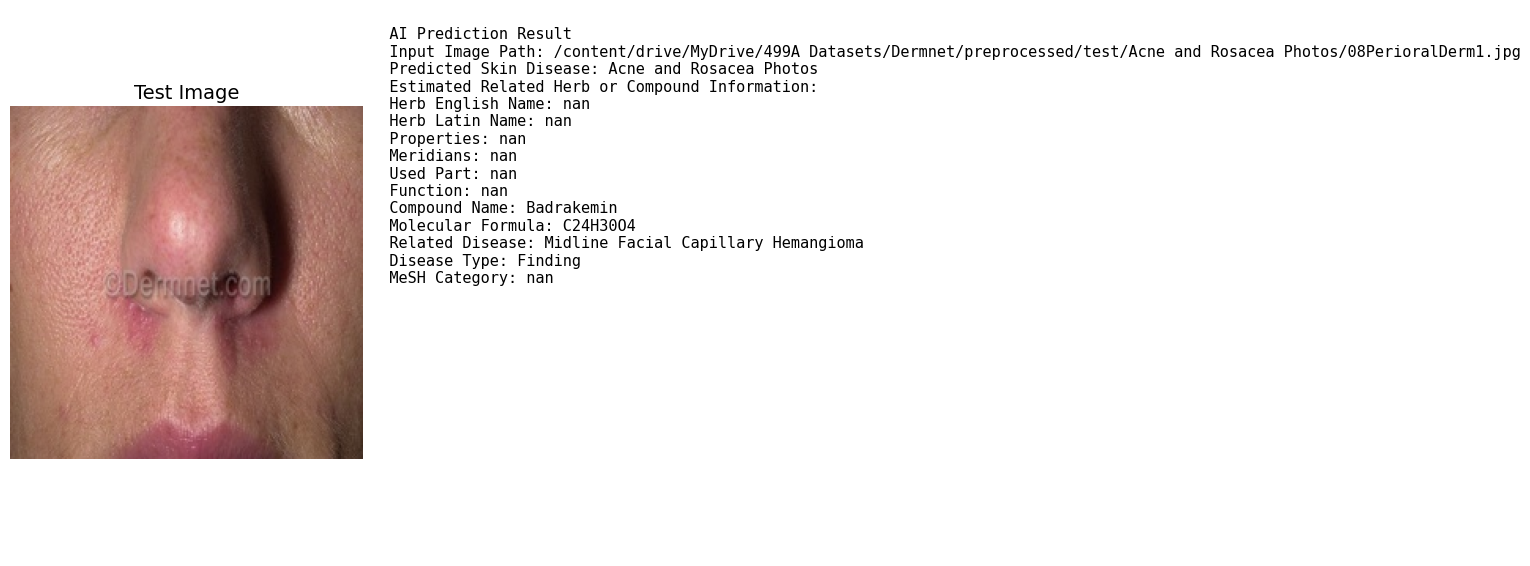

In [50]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from transformers import CLIPProcessor, CLIPModel

# Load CLIP model and processor
MODEL_NAME = "openai/clip-vit-base-patch32"
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(device)
processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model.eval()

# Load metadata and embeddings
meta = pd.read_csv(METADATA_PATH)
herb = pd.read_csv(HERB_TEXT_PATH, low_memory=False)

img_train_embs = np.load(os.path.join(EMB_SAVE_DIR, "img_train_emb.npy"))
img_test_embs = np.load(os.path.join(EMB_SAVE_DIR, "img_test_emb.npy"))
herb_text_embs = np.load(os.path.join(EMB_SAVE_DIR, "herb_text_emb.npy"))

image_test_paths = meta[meta['subset'].str.lower() == 'test']['image_path'].tolist()
herb_texts = herb['text_for_vlm'].fillna('').astype(str).tolist()

# Choose a test image
test_idx = 22  # change index or set your own image path
test_image_path = image_test_paths[test_idx]
test_image = Image.open(test_image_path).convert("RGB")

# Compute CLIP embedding
inputs = processor(images=test_image, return_tensors="pt").to(device)
with torch.no_grad():
    test_emb = clip_model.get_image_features(**inputs)
    test_emb = test_emb / test_emb.norm(p=2, dim=-1, keepdim=True)
test_emb = test_emb.cpu().numpy()

# Predict disease
sim_to_train = cosine_similarity(test_emb, img_train_embs)[0]
top_train_idx = np.argmax(sim_to_train)
predicted_disease = meta[meta['subset'].str.lower() == 'train'].iloc[top_train_idx]['class_name']

# Predict herb or compound
sim_to_herbs = cosine_similarity(test_emb, herb_text_embs)[0]
top_herb_idx = np.argmax(sim_to_herbs)
predicted_herb_text = herb_texts[top_herb_idx]

# Parse herb info with labels
parts = [p.strip() for p in predicted_herb_text.split('|') if str(p).lower() != 'nan' and p.strip()]
labels = [
    "   Herb English Name", "   Herb Latin Name", "   Properties", "   Meridians",
    "   Used Part", "   Function", "   Compound Name", "   Molecular Formula",
    "   Related Disease", "   Disease Type", "   MeSH Category"
]

# Display image and readable text
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(test_image)
ax[0].axis("off")
ax[0].set_title("Test Image", fontsize=14)

# Text
text_summary = f"""
   AI Prediction Result
   Input Image Path: {test_image_path}
   Predicted Skin Disease: {predicted_disease}
   Estimated Related Herb or Compound Information:
"""

for label, value in zip(labels, parts):
    text_summary += f"{label}: {value}\n"
if len(parts) < len(labels):
    for label in labels[len(parts):]:
        text_summary += f"{label}: (Not Available)\n"


ax[1].text(0, 1, text_summary, fontsize=11, va='top', family='monospace')
ax[1].axis("off")

plt.tight_layout()
plt.show()
